# Exogenous degrees of freedom

As we mentioned in previous pages, some degrees of freedom can be
designated as *exogenous*, meaning that their behavior is determined
by some external process that we do not model explicitly. In practice,
that means that the acceleration of such a degree of freedom must
by explicitly provided at every time step while the state vector is being
advanced.

In [1]:
using RigidBodyTools
using Plots

As usual, we will demonstrate this via an example. In the example,
a single flat plate will be commanded to pitch upward by 45 degrees
about its leading edge. It will move steadily in the +x direction.
However, its y acceleration will vary randomly via some exogenous process.

In [2]:
Xp_to_jp = MotionTransform(0.0,0.0,0.0)
Xc_to_jc = MotionTransform(0.5,0.0,0.0)
dofs = [SmoothRampDOF(0.4,π/4,0.5),ConstantVelocityDOF(1.0),ExogenousDOF()]
joint = Joint(FreeJoint2d,0,Xp_to_jp,1,Xc_to_jc,dofs)
joints = [joint]

b = ThickPlate(1.0,0.05,0.02)
bodies = BodyList([b])

ls = RigidBodyMotion(joints,bodies)

1 linked system(s) of bodies
   1 bodies
   1 joints


Let's initialize the state vector and its rate of change

In [3]:
bc = deepcopy(bodies)
dt, tmax = 0.01, 3.0
t0, x0 = 0.0, init_motion_state(bc,ls)
dxdt = zero(x0)
x = copy(x0)

4-element Vector{Float64}:
 3.036647512353532e-7
 0.0
 0.0
 0.0

Note that the state vector has four elements. The first two are
associated with the prescribed motions for rotation and x translation.
The third is the y position, the exogenous degree of freedom. And the
fourth is the y velocity.

Why the y velocity? Because the exogenous behavior is specified via its
acceleration. This acceleration will need to be provided at each step in
the time marching. To help with this, we create a zero vector:

In [4]:
a_edof = zero_joint(ls,dimfcn=exogenous_dimension)
a_udof = zero_joint(ls,dimfcn=unconstrained_dimension);

Now, `a_edof` is not empty, as it was in the previous example, but has a single element. We will set this
element's value inside the loop, using a random value chosen from a
normal distribution. We will record the history of the state while
we advance it

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_xOFKTS3eRC.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_xOFKTS3eRC.gif")
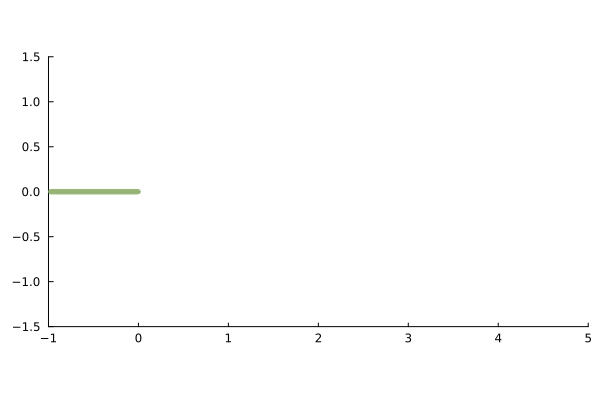

In [5]:
xhist = []
@gif for t in t0:dt:t0+tmax
  a_edof[1] = randn()

  motion_rhs!(dxdt,x,t,a_edof,a_udof,ls,bc)
  global x += dxdt*dt
  update_body!(bc,x,ls)

  push!(xhist,copy(x))
  plot(bc,xlims=(-1,5),ylims=(-1.5,1.5))
end every 5

Let's plot the exogenous state and its velocity

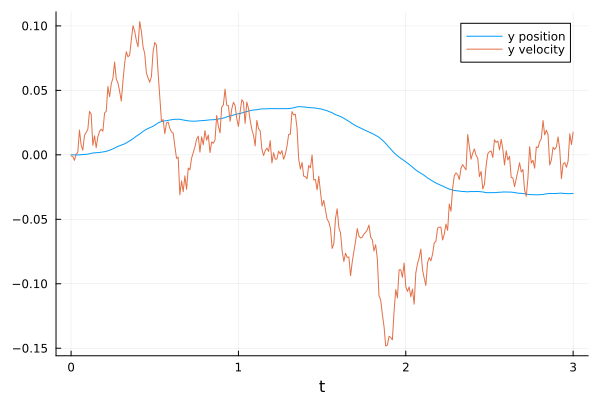

In [6]:
plot(t0:dt:t0+tmax,map(x -> x[3],xhist),label="y position",xlabel="t")
plot!(t0:dt:t0+tmax,map(x -> x[4],xhist),label="y velocity")

The variation in velocity is quite noisy (and constitutes a random walk).
In contrast, the change in position is relatively smooth, since it represents
an integral of this velocity.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*